# Garbage type detection with computer vision

In this notebook, we will show you have you can use Computer Vision (CV) to identify the type of waste (i.e plastic, glass, metal, etc) visible in an image.

As CV model, we use a Convolutional Neural Network (CNN) architecture which is currently the state-of-the-art architecture CV tasks (i.e. classification, segmentatino, object detectin, etc). The architecture is implemented with the Deep Learning (DL) library PyTorch.

We use the [Garbage Classification Dataset](https://www.kaggle.com/asdasdasasdas/garbage-classification)  to train our model. The dataset is composed 2527 images of 6 classes: 
1. cardboard (403)
2. glass (501)
3. metal (410)
4. paper(594)
5. plastic (482)
6. trash (137)

Figures 1 to 3 show examples of garbadge images from the dataset.
<figure>
    <img src='html_images/cardboard36.jpg' alt='Fig.1: cardboard' />
    <figcaption>Fig.1: cardboard</figcaption>
</figure>
<figure>
    <img src='html_images/plastic11.jpg' alt='Fig.2: plastic' />
    <figcaption>Fig.2: plastic</figcaption>
</figure>
<figure>
    <img src='html_images/trash134.jpg' alt='Fig.3: trash' />
    <figcaption>Fig.3: trash</figcaption>
</figure>

As we can see, the dataset is relatively balanced, without any classes below 10% of the total dataset size. Nevertheless, the total number of images (2527) is too small to properly train a CV model from scratch. Therefore, we will use the _transfer learning_ approach, also known as _fine tunning_ approach, where we use a base model already trained on a much larger, but different, dataset and use our samll garbage dataset for an extra training step. 

As base model for you architecture, we use [RestNet18](https://arxiv.org/abs/1512.03385), a medium size CNN composed of 18 convolutional layers. Desipte being smaller and less perfromant than larger CNN models, ResNet18 offers excellent accuracy on the garbage dataset and can be trained easily on "small" accelerated computers, i.e. computers with consumer grade GPU.

This notboook is based on the [MNIST Training using PyTorch](https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/pytorch_mnist/pytorch_mnist.ipynb) tutorial.

# Prerequisite

Before running this notebook, run the following code in your terminal:
```
$ pip install -r requirements.txt
```
Or if you run this notebook in [Amazon SageMaker Notebook](https://docs.aws.amazon.com/sagemaker/latest/dg/nbi.html) or [Amazon SageMaker Studio](https://aws.amazon.com/sagemaker/studio/), simply select the GPU optimized PyTorch kernel.

# Train a model with Amazon SageMaker Training

Training a modern Deep Neural Network (DNN), such as a CNN, requires large computers, accelerated by dedicated GPU. These GPU, such as the Nvidia V100, cost more than 10'000 USD a piece, and several GPU's are generally required to train large model from scratch. In our case, we use _transfer learning_ to reduce computational time and power, but we still need a large GPU to fine-tune our model in an acceptable timeframe (i.e. a few minutes). Without GPU, the training would last several hours, maybe days depending on the CPU power.

Such Computational requirement can be a major issue for businesses and academics. To solve this issue, we will use Amazon SageMaker Training. Amazon SageMaker Training provides and manages the infrastructure to train machine learning models. SageMaker Training can operate in four different modes, depending on your requirements and the problem at hand:
1. `SageMaker built-in algorithms`: everything is managed by Sagemaker, you only bring your data
2. `Sagemaker framework`: you bring the training script and your data, SageMaker takes care of the rest.
3. `SageMaker BYO algorithm and framework`: you bring the training script, the libraries used in the training (via a Docker container) and the data. SageMaker takes care of the rest.
4. `AWS Marketplace algorithm`: very similar to no 3, but an external vendor provides the training script and the libraries. You bring only the data. From the user perspective, this is very similar to `SageMaker built-in algorithms`. 

<figure>
    <img src='html_images/sagemaker_training_modes.png' alt='Fig.4' />
    <figcaption>Fig.4: SageMaker Training: available training modes and their implication</figcaption>
</figure>
Under the hood, SageMaker Trainging perform the training steps within a Docker container. 

## An overview of Docker

If you're familiar with Docker already, you can skip ahead to the next section.

For many data scientists, Docker containers are a new technology. But they are not difficult and can significantly simply the deployment of your software packages.

Docker provides a simple way to package arbitrary code into an image that is totally self-contained. Once you have an image, you can use Docker to run a container based on that image. Running a container is just like running a program on the machine except that the container creates a fully self-contained environment for the program to run. Containers are isolated from each other and from the host environment, so the way your program is set up is the way it runs, no matter where you run it.

Docker is more powerful than environment managers like conda or virtualenv because (a) it is completely language independent and (b) it comprises your whole operating environment, including startup commands, and environment variable.

A Docker container is like a virtual machine, but it is much lighter weight. For example, a program running in a container can start in less than a second and many containers can run simultaneously on the same physical or virtual machine instance.

Amazon SageMaker Training invokes a Docker for in a specific way. The following section outline what a training code/script needs to do to work within the SageMaker environment.


## The training script

For our case, we will use the `Sagemaker framework` mode as it is flexible while removeing infrastructure maintenance from the data scientist. For the `Sagemaker framework` mode, we only bring the training code via a regular python script. During execution in the SageMaker Docker container, the script need to be aware of the following folder structure at runtime:
```
    /opt/ml
    |-- input
    |   |-- config
    |   |   |-- hyperparameters.json
    |   |    -- resourceConfig.json
    |    -- data
    |        -- <channel_name>
    |            -- <input data>
    |-- model
    |   -- <model files>
     -- output
        -- failure
``` 

**The input**
    
* `/opt/ml/input/config` contains information to control how your program runs. hyperparameters.json is a JSON-formatted dictionary of hyperparameter names to values. These values are always strings, so you may need to convert them. resourceConfig.json is a JSON formatted file that describes the network layout used for distributed training.
* `/opt/ml/input/data/<channel_name>` (for File mode) contains the input data for that channel. The channels are created based on the call to CreateTrainingJob, but it's generally important that channels match algorithm expectations. The files for each channel are copied from S3 to this directory, preserving the tree structure indicated by the S3 key structure.
* `/opt/ml/input/data/<channel_name>_<epoch_number>` (for Pipe mode) is the pipe for a given epoch. Epochs start at zero and go up by one each time you read them. There is no limit to the number of epochs that you can run, but you must close each pipe before reading the next epoch.
    
**The output**

* `/opt/ml/model` is the directory where you write the model that your algorithm generates. Your model can be in any format that you want. It can be a single file or a whole directory tree. SageMaker packages any files in this directory into a compressed tar archive file. This file is made available at the S3 location returned to the DescribeTrainingJob result. The model artefact can be saved in any format. But to be usable with SageMaker Endpoints, it must be saved in a specific format. For example, the SageMaker Pytorch Endpoint must be save with the function `torch.save()` in  `/opt/ml/model/model.pth`.
* `/opt/ml/output` is a directory where the algorithm can write a file failure that describes why the job failed. The contents of this file are returned to the FailureReason field of the DescribeTrainingJob result. For jobs that succeed, there is no reason to write this file as it is ignored.

**The envirnoment variables**

Amazon SageMaker injects several useful environment variables in the runtime used by the training script. A list of these variable can be found [here](https://github.com/aws/sagemaker-training-toolkit/blob/master/ENVIRONMENT_VARIABLES.md). Below are listed the most commonly used SageMaker Training environment variables:
* `SM_MODEL_DIR`: by default, this is the folder `/opt/ml/model` mentioned above. This is where all the trained artefacts should be saved.
* `SM_CHANNEL_<CHANNEL>`: the data channel. The channel names are defined in the `fit` method used to start the training (see a few cell below). e.g. a data scientist might use three data channels for his train: _training_, _val_ and _finaleval_. The environement variables will be `SM_CHANNEL_TRAINING`, `SM_CHANNEL_VAL` and `SM_CHANNEL_FINALEVAL`.

**The script**

The training script is available in `train.py`. The code should be familiar if you already used PyTorch. The only parts specific for execution in the SageMaker Training environement are the last lines in the function `parse_arguments()`:
```python
def parse_arguments():
    """
    Parse the script input argument and some environment variables provided at runtime by 
    Amazon SageMaker Training
    """
    parser = argparse.ArgumentParser()
    
    # ...
    # some classic arguments used in training, such as the number of epoch, the learning rate, etc.
    # ...
    
    # Container environment
    parser.add_argument("--hosts", type=list, default=json.loads(os.environ["SM_HOSTS"]))
    parser.add_argument("--current-host", type=str, default=os.environ["SM_CURRENT_HOST"])
    parser.add_argument("--model-dir", type=str, default=os.environ["SM_MODEL_DIR"])
    parser.add_argument("--training-dir", type=str, default=os.environ["SM_CHANNEL_TRAINING"])
    parser.add_argument("--testing-dir", type=str, default=os.environ["SM_CHANNEL_TESTING"])
    parser.add_argument("--num-gpus", type=int, default=os.environ["SM_NUM_GPUS"])
    
    # ...
```
Several environment variables are read in the code snippet above, with the data channels amoung the most important. The script expects two channel: _training_ and _testing_. Let's keep these in mind.

# Train the model

In [6]:
from sagemaker.pytorch import PyTorch
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

estimator = PyTorch(
    entry_point='train.py',
    role=role,
    py_version='py3',
    framework_version='1.8.0',
    instance_count=2,
    instance_type='ml.g4dn.xlarge',
    hyperparameters={
        'epochs': 10,
        'backend': 'gloo',
        # 'lr': 1e-4,
        # 'batch_size': 64
    }
)

In the cell above, we created an _PyTorch Estimator_ object. This object holds all the information required for the training, such as the hyperparameters which are passed to the training script as input arguments and processed in the function `parse_arguments()` in the training script.

We are now ready to train the model with the `fit` method. The data channel _training_ and _testing_ are defined here. These must match the channel names used in the training script.

In [7]:
bucket = '<bucket here>'

train_inputs = f's3://{bucket}/data/train'
test_inputs = f's3://{bucket}/data/test'

In [8]:
estimator.fit({'training': train_inputs, 'testing': test_inputs}, wait=True)

2021-10-27 09:50:02 Starting - Starting the training job...
2021-10-27 09:50:04 Starting - Launching requested ML instancesProfilerReport-1635328202: InProgress
...
2021-10-27 09:51:03 Starting - Preparing the instances for training.........
2021-10-27 09:52:23 Downloading - Downloading input data...
2021-10-27 09:53:03 Training - Downloading the training image............
2021-10-27 09:55:04 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-10-27 09:54:49,100 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-10-27 09:54:49,121 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-10-27 09:54:59,481 sagemaker-training-toolkit INFO     Imported framework sagema

# Deploy and test the model

We can use the test images to evalute the endpoint. The accuracy of the model depends on the training procedure and hyper parameters, i.e. the number of training epoch, the learning rate, the training set size, etc.

Let's deploy the estimator. The estimator is deployed on Amazon SageMaker Endpoint, a service that takes care of everything required for inference, such as:
* Communication API (i.e. Rest API) for input and output payload
* Compute instance scalling depending on the load
* Compute instance maintenance

In [9]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

# from sagemaker.predictor import Predictor
# from sagemaker.serializers import NumpySerializer
# from sagemaker.deserializers import NumpyDeserializer

# predictor = Predictor(endpoint_name='pytorch-training-2021-08-03-11-08-41-872', serializer=NumpySerializer(), deserializer=NumpyDeserializer())

-------!

Let's download the test dataset locally and get inference on these images

In [10]:
!aws s3 sync {test_inputs} ./data/test

download: s3://ch-workshop/data/test/cardboard/cardboard1.jpg to data/test/cardboard/cardboard1.jpg
download: s3://ch-workshop/data/test/cardboard/cardboard104.jpg to data/test/cardboard/cardboard104.jpg
download: s3://ch-workshop/data/test/cardboard/cardboard103.jpg to data/test/cardboard/cardboard103.jpg
download: s3://ch-workshop/data/test/cardboard/cardboard107.jpg to data/test/cardboard/cardboard107.jpg
download: s3://ch-workshop/data/test/cardboard/cardboard110.jpg to data/test/cardboard/cardboard110.jpg
download: s3://ch-workshop/data/test/cardboard/cardboard101.jpg to data/test/cardboard/cardboard101.jpg
download: s3://ch-workshop/data/test/cardboard/cardboard123.jpg to data/test/cardboard/cardboard123.jpg
download: s3://ch-workshop/data/test/cardboard/cardboard127.jpg to data/test/cardboard/cardboard127.jpg
download: s3://ch-workshop/data/test/cardboard/cardboard136.jpg to data/test/cardboard/cardboard136.jpg
download: s3://ch-workshop/data/test/cardboard/cardboard125.jpg to d

In [11]:
from torchvision import transforms, datasets
import torch

test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.6405, 0.6067, 0.5659], [0.2144, 0.2134, 0.2338])
    ])

test_dataset = datasets.ImageFolder('./data/test', transform=test_transforms)

test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=True,
)

batch = next(iter(test_dataloader))[0]

[2021-10-27 10:03:53.464 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-c630bdb4e3ad8d68ab6e5727a214:87 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-10-27 10:03:53.490 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-c630bdb4e3ad8d68ab6e5727a214:87 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


INFO:matplotlib.font_manager:Generating new fontManager, this may take some time...


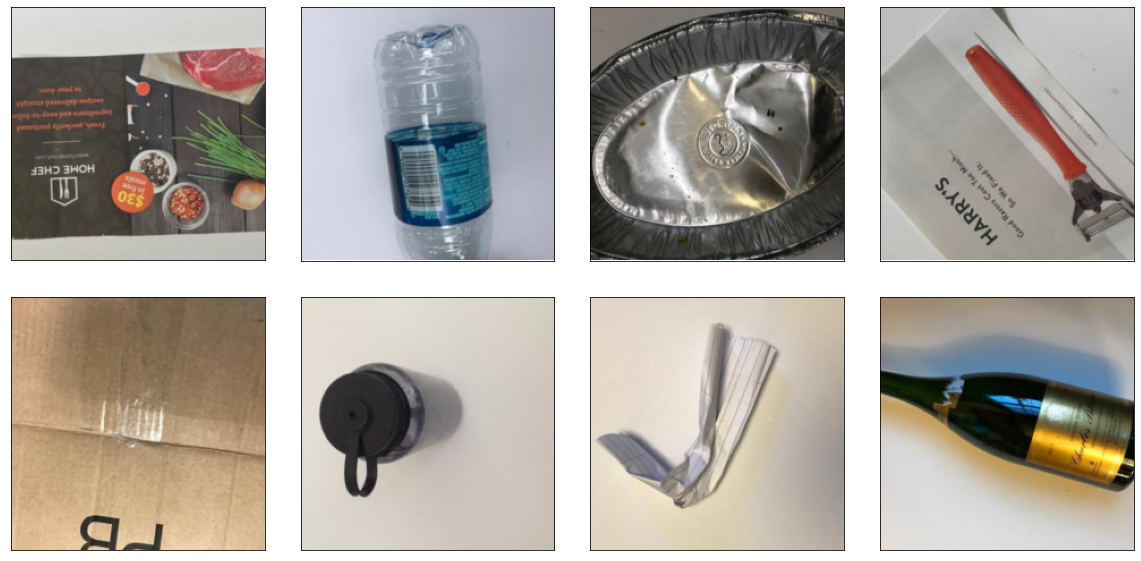

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

mean = torch.tensor([0.6405, 0.6067, 0.5659])
stdev = torch.tensor([0.2144, 0.2134, 0.2338])

def imshow(axis, inp, pred=None):
    inp = inp.permute(1,2,0)
    inp = inp * stdev + mean
    axis.imshow(inp)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    if pred:
        axis.set_title(pred)

fig = plt.figure(1, figsize=(30, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.5)

for img, ax in zip(batch, grid):
    imshow(ax, img)

In [13]:
response = predictor.predict(batch.numpy())
classes = [test_dataset.classes[i] for i in response.argmax(axis=1)]
print(f"Raw prediction result: {response}")

Raw prediction result: [[ 0.5537107  -2.29965734 -0.09341255  4.05133438 -0.72546029 -0.80336106]
 [-2.4189775   0.92636573  0.4451043  -0.6068579   4.03234529  0.46271843]
 [-0.41640711  0.25874788  5.00442171 -1.65693259  1.29290652 -0.44263884]
 [-0.14213526  0.27997988 -1.67405915  5.89251232 -0.5912599  -0.40811998]
 [ 5.05108595 -1.0600661  -1.12915063 -0.49953955 -2.14989853 -1.83494067]
 [-0.51895785  2.36737561  0.84448981 -0.97758842  0.86763066 -1.01542401]
 [-0.41648239  0.23679617 -0.42064697  2.20565987  0.41881344  1.51732147]
 [-0.08704358  3.44236016  1.5270834  -0.75343966 -0.3601495  -1.24120474]]


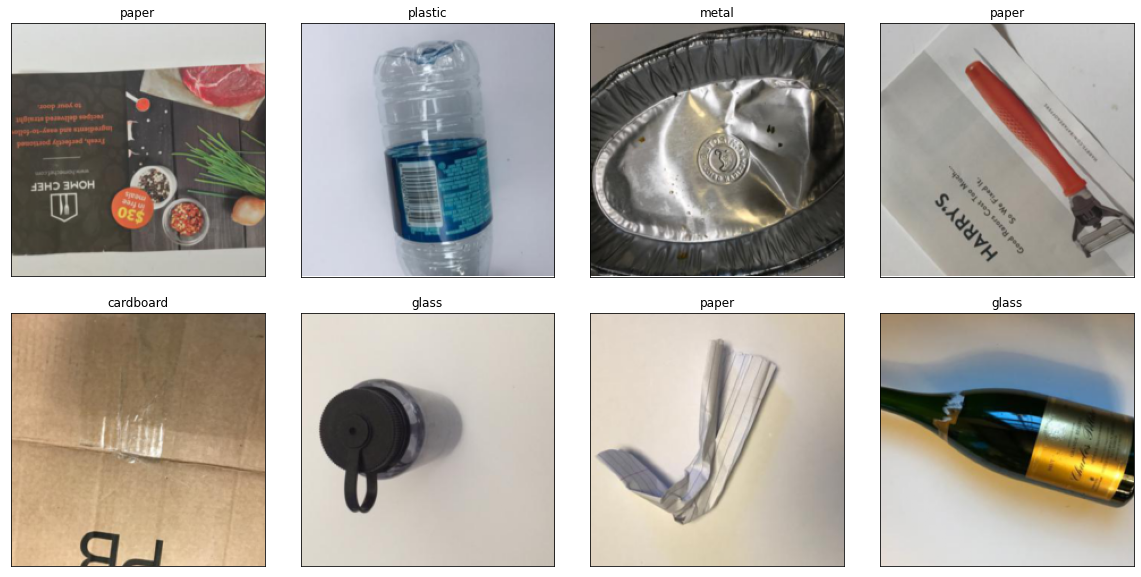

In [14]:
fig = plt.figure(1, figsize=(30, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.5)

for img, ax, pred in zip(batch, grid, classes):
    imshow(ax, img, pred)

# Cleanup

After we have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it (not important in Event accounts).

In [15]:
sagemaker_session.delete_endpoint(
    endpoint_name = predictor.endpoint_name
)

INFO:sagemaker:Deleting endpoint with name: pytorch-training-2021-10-27-09-58-14-668
